In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

  Attempting uninstall: webdataset
    Found existing installation: webdataset 0.1.103
    Uninstalling webdataset-0.1.103:
      Successfully uninstalled webdataset-0.1.103


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv
import pickle # for loading and saving variables

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

In [3]:
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version

In [4]:
version('webdataset')

'0.1.62'

In [6]:
def plot_raw_EEG(data, n_sample):
    numChan = 24
    if len(data[0]) == 2: # torch batch
        x_data = data[:][0]
    else:
        x_data = data
    row = col = int(np.sqrt(n_sample))
    fig = plt.figure(figsize=(row*10, col*10))
    outer = gridspec.GridSpec(row, col)
    print(n_sample)
    for i in range(n_sample):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg = x_data[i,:,:,:]
        npimg = np.reshape(npimg,(numChan,256))
        yax = None
        for j in range(numChan):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [7]:
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Where input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    clean_idx = []
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
        clean_x_idx = []
        for i in range(x.shape[0]):
            sample = x[i,:,:,:]
            if np.max(sample) < 5000 and np.min(sample) > -5000:
                clean_x_idx.append(i)
        print("clean sample amplitude threshold:",len(clean_x_idx))
        
        clean_subj_idx = []
        for i in range(0,x.shape[0],81):
#             print("i:",i)
            subj_data = x[i:i+80,:,:,:]
            
            mean_mat = np.mean(subj_data)
            std_mat = np.std(subj_data)
            
            subj_data = (subj_data - mean_mat)/std_mat
#             print(f"sanity check - mean before {mean_mat}, after {np.mean(subj_data)}")
#             print(f"sanity check - var before {var_mat}, after {np.var(subj_data)}")
            
#             x[i:i+80,:,:,:] = subj_data
            
            subj_std = np.std(subj_data)
#             print("subject max:", np.max(subj_data.flatten()))
#             print("subject std:",subj_std)
            if subj_std < 5:
                clean_subj_idx.extend(list(range(i,i+80)))
        print("clean sample std<5:",len(clean_subj_idx))
        
        clean_transient = []
        for i in range(x.shape[0]):
            sample = x[i,:,:,:]
            transient = np.diff(sample, axis=2)
            assert(transient.shape == (1,24,255))
            transient_std = np.std(transient)
            if transient_std < 3:
                clean_transient.append(i)
        print("clean transient std<3:",len(clean_transient))
        
        clean_idx = intersection(clean_x_idx, clean_subj_idx)
        clean_idx = intersection(clean_idx, clean_transient)
        print("num of clean trials:", len(clean_idx))
        
        # min max scaling
        for i in range(0,x.shape[0],81):
            subj_data = x[i:i+80,:,:,:]
            
            subj_min = np.min(subj_data)
            subj_max = np.max(subj_data)
            
            subj_data = (subj_data - subj_min)/(subj_max-subj_min)
            x[i:i+80,:,:,:] = subj_data
        clean_idx = sorted(clean_idx)
        x = x[clean_idx,:,:,:]
#         x = x[:2000,:,:,:]
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = f[f'Y_{role}']
#     print(clean_idx)
    y = y[clean_idx]
#     y = y[:2000]
    return EEGDataset(x, y, role=='train', role=='val'), x, y

class EEGDataset(Dataset):
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

In [8]:
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data, X_train, Y_train = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')
# val_data, X_val, Y_val = load_data(path, 'val', winLength, numChan, srate, feature, one_channel)
# print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
# print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')

clean sample amplitude threshold: 70942


/home/dtyoung/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


clean sample std<5: 70320
clean transient std<3: 21218
num of clean trials: 20723


/home/dtyoung/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in true_divide


X_train shape: 20723, (1, 24, 256)
Y_train shape: 20723, ()


4


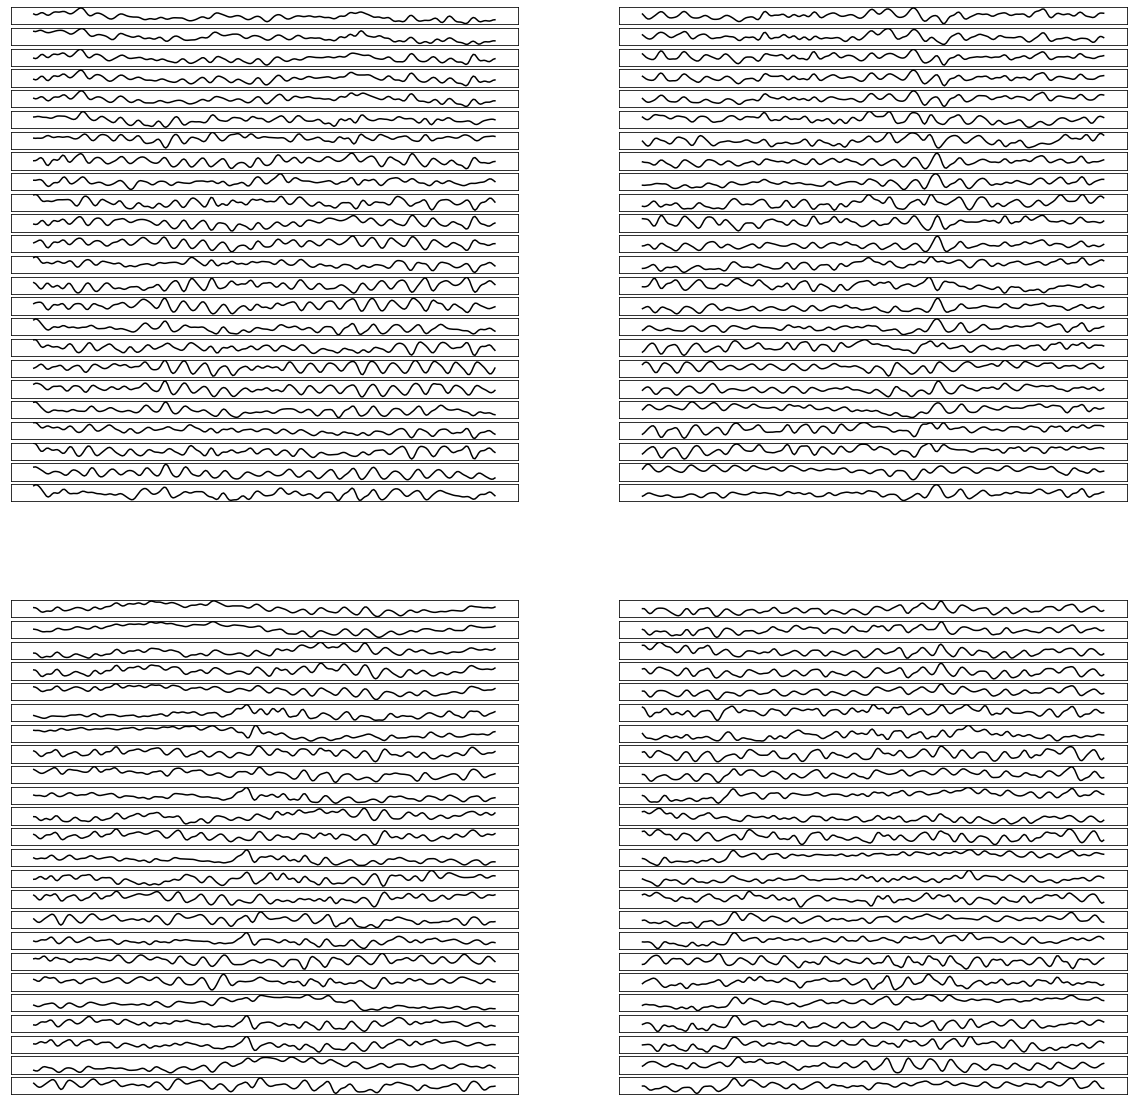

In [9]:
fig = plot_raw_EEG(train_data, 4)

In [8]:
class Logger():
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{self.experiment_name}-{info}")
        
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

isDebug = False

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

latent_dim = 10
print('latent dimension:', str(latent_dim))
def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
# train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
# val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cuda
latent dimension: 10


In [9]:
class VAE(nn.Module): 
    
    def __init__(self, latent_dim):
        # latent_dim: dimension of the latent representation vector
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = 4
        self.gamma = 1000.
        self.loss_type = 'H'
        self.C_max = torch.tensor([25])
        self.C_stop_iter = 1e5
        self.autoencoder = False # toggle whether in autoencoder mode
        
        encoder_l = [self.encoder_conv_block(True)]
        for i in range(2):
            encoder_l.append(self.encoder_conv_block())
        encoder_l.append(self.encoder_conv_block(False, 5, 5, 3, 1, 0))
        encoder_l.append(nn.Flatten())
        self.encoder_before_last = nn.ModuleList(encoder_l)
        self.encoder_mu = self.encoder_linear_block(150, latent_dim) #960
        self.encoder_log_var = self.encoder_linear_block(150, latent_dim)
       
        self.autoencoder_linear = self.encoder_linear_block(150, latent_dim)
                            
        decoder_l = [self.decoder_linear_block(latent_dim, 150)]
        decoder_l.append(self.decoder_conv_block(False, 5, 5, 3, 1, 0))
        for i in range(2):
            decoder_l.append(self.decoder_conv_block())
        decoder_l.append(self.decoder_conv_block(True))
        self.decoder = nn.ModuleList(decoder_l)
    
    def encoder_conv_block(self, is_start=False, in_channels=5, out_channels=5, kernel_size=6, stride=2, padding=2):
        if is_start:
            return nn.Sequential(
                nn.Conv2d(1, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    def encoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def decoder_conv_block(self, is_last=False, in_channels=5, out_channels=5, kernel_size=6, stride=2, padding=2):
        if is_last:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, 1, kernel_size, stride, padding),
                nn.BatchNorm2d(1),
                nn.ReLU()
#                 nn.Sigmoid()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
    
    def decoder_linear_block(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Linear(in_chan, out_chan),
            nn.ReLU()
        )
    
    def forward(self, x):
        for f in self.encoder_before_last:
            x = f(x)
        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)
        if self.autoencoder:
            z = self.autoencoder_linear(x)
        else:
            z = self.reparameterize(mu, log_var)
        
        x = self.decode(z)
            
        return x, mu, log_var
    
    def encode(self,x):
        for f in self.encoder_before_last:
            x = f(x)
        mu = self.encoder_mu(x)
        log_var = self.encoder_log_var(x)
        z = self.reparameterize(mu, log_var)
        return z
    
    def decode(self, z):
        x = self.decoder[0](z)
        x = x.view(-1, 5, 1, 30) # reshape the tensor to be expected dimension for ConvTranspose
        for i in range(1,len(self.decoder)):
            f = self.decoder[i]
            x = f(x) 
        return x
    
    def generate_sample(self, n_sample):
        z = torch.randn((n_sample, self.latent_dim))
        return self.decode(z)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation. = torch.pow(torch.exp(log_var),0.5)
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def sample_z(self, mu, sigma):
        # Input
        #     mu:     [batch_size, self.latent_size] the predicted mu value for each sample in the batch
        #     sigma:  [batch_size, self.latent_size] the predicted diag elem of sigma value for each sample in the batch
        # Output
        #     z: [batch_size, self.latent_size] the latent representation of each sample in the batch
        # Reference: https://agustinus.kristia.de/techblog/2016/12/10/variational-autoencoder/
        
        # eps ~ N(0,1)        
        batch_size = mu.size()[0]
        eps = torch.randn((batch_size,1), device=device, dtype=dtype)
        z = mu + sigma/2*eps
        
        return z

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        ori = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss = F.mse_loss(recons, ori) #F.binary_cross_entropy(recons, ori) #

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0) # is it - log_var?
        # -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

In [10]:
class ToCorrectSizeTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        correct_size_sample = torch.zeros(1,24,256)
        correct_size_sample[0,:,0:28] = sample[0,2:26,:]
        return correct_size_sample

vae = VAE(latent_dim)
vae = vae.to(device=device)

if isDebug:
    mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(),ToCorrectSizeTensor()]))
    mnist_test = torchvision.datasets.MNIST('./mnist', train=False, download=True, transform = transforms.Compose([transforms.ToTensor(), ToCorrectSizeTensor()]))
    sample = torch.unsqueeze(mnist_train[0][0],0)
    sample = sample.to(device=device)
else:
    sample = torch.rand((1, 1, 24, 256), device=device)
# print(vae)                         
from pytorch_model_summary import summary
# print(summary(vae, sample, show_input=False)) 
print(summary(vae, sample, show_input=False))

--------------------------------------------------------------------------
         Layer (type)        Output Shape         Param #     Tr. Param #
             Conv2d-1     [1, 5, 12, 128]             185             185
        BatchNorm2d-2     [1, 5, 12, 128]              10              10
               ReLU-3     [1, 5, 12, 128]               0               0
             Conv2d-4       [1, 5, 6, 64]             905             905
        BatchNorm2d-5       [1, 5, 6, 64]              10              10
               ReLU-6       [1, 5, 6, 64]               0               0
             Conv2d-7       [1, 5, 3, 32]             905             905
        BatchNorm2d-8       [1, 5, 3, 32]              10              10
               ReLU-9       [1, 5, 3, 32]               0               0
            Conv2d-10       [1, 5, 1, 30]             230             230
       BatchNorm2d-11       [1, 5, 1, 30]              10              10
              ReLU-12       [1, 5, 1,

KL divergence loss
![kl_loss](https://github.com/dungscout96/deep-representation-learning-EEG/blob/master/images/kl_loss.png?raw=1)

In [11]:
# def beta_vae_loss(mu_hat, sigma_hat, x_hat, x_target):
#     likelihood_loss = F.mse_loss(x_hat, x_target)
#     kl_loss = 0.5 * torch.sum(torch.exp(sigma_hat) + torch.pow(mu_hat,2) - torch.ones((1,mu_hat.size()[1]), device=device, dtype=dtype) - mu_hat, axis=1)
#     return torch.mean(likelihood_loss + kl_loss) # average the loss of batch

def train(model, loader_train, optimizer, loader_val, epochs, logger, device, dtype, M_N):
    """ 
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - logger: Logger object for logging purpose
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_array = []
    recon_loss = []
    kld_loss = []
    decoder_weight_norm = []
    encoder_weight_norm = []
    encoder_mu_norm = []
    encoder_log_var_norm = []
    num_batch = 0
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    print('Begin trainning...')
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            if e == 0:
                num_batch += 1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            # mu_hat, sigma_hat, x_hat = model(x)
            
            # loss = beta_vae_loss(mu_hat, sigma_hat, x_hat, x)
            
            x_hat, mu_hat, sigma_hat = model(x)
            
            loss_dict = model.loss_function(x_hat, x, mu_hat, sigma_hat,M_N=M_N)
            loss = loss_dict["loss"]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # collect info
            loss_array.append(loss.item())
            recon_loss.append(loss_dict["Reconstruction_Loss"].item())
            kld_loss.append(loss_dict["KLD"].item())
            weights_norm = 0
            for layers in model.decoder:
                for layer in layers:
                    if isinstance(layer, nn.ConvTranspose2d):
                        weights_norm += np.linalg.norm(layer.weight.cpu().detach().numpy())
            decoder_weight_norm.append(weights_norm)
            weights_norm = 0
            for layers in model.encoder_before_last:
                if not isinstance(layers, nn.Flatten):
                    for layer in layers:
                        if isinstance(layer, nn.Conv2d):
                            weights_norm += np.linalg.norm(layer.weight.cpu().detach().numpy())
            encoder_weight_norm.append(weights_norm)
            
            encoder_mu_norm.append(np.linalg.norm(model.encoder_mu[0].weight.cpu().detach().numpy()))
            encoder_log_var_norm.append(np.linalg.norm(model.encoder_log_var[0].weight.cpu().detach().numpy()))
            weight_norm = {'decoder': decoder_weight_norm, 'encoder_before_last': encoder_weight_norm, 'encoder_mu': encoder_mu_norm, 'encoder_log_var': encoder_log_var_norm}
            if t % 100 == 0:
                # logger.writer.add_scalar("Loss/train", loss.item(), e*num_batch+t)
                # logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print(f'Epoch {e}, Iteration {t}, loss = {loss.item()}, recon_loss = {loss_dict["Reconstruction_Loss"].item()}, kld_loss = {loss_dict["KLD"].item()}')
                # , mu_hat = {mu_hat}, log_var_hat = {sigma_hat}
        # get validation loss
#         model.eval()
#         val_loss = check_accuracy(loader_val, 'val', model, device, dtype, logger)
#         logger.writer.add_scalar("Acc/valid", val_acc, e)        
#         logger.log()
        
        # Save model per fixed epoch interval
        # if e > 0 and e % 10 == 0:
        #     logger.save_model(model,f"epoch{e}")
#         elif val_acc >= 0.83:
#             logger.save_model(model,f"valacc83-epoch{e}")
#         elif val_acc >= 0.84:
#             logger.save_model(model,f"valacc84-epoch{e}")
    # save final model
    # logger.save_model(model,f"epoch{e}")
    return model, loss_array, recon_loss, kld_loss, weight_norm

In [12]:
def load_experiment(experiment_path):
    trained_model = VAE(latent_dim)
    trained_model.load_state_dict(torch.load(f'{experiment_path}/model'))
    file = open(f"{experiment_path}/params.pkl",'rb')
    params = pickle.load(file)
    return trained_model, params


In [13]:
new_train = True

vae = VAE(latent_dim)

if new_train:
    params = {
        "isDebug": isDebug,
        "batch_size": 128,
        "M_N": 1, # len(train_data)/batch_size, # for VAE,
        "epoch": 150,
        "lr": 0.001,
        "seed": 0,
        "beta": 0,
        "isAutoencoder": True,
        "amplitude_clean": True,
        "std_threshold": True,
        "transient_threshold": True,
        "min_max_norm": True,
        "num_sam": len(train_data)
    }
else:
    vae, params = load_experiment('experiment/beta-0/epochs20-24')
    params['epoch'] = 5
    print("experiment params:", params)

vae.autoencoder = params['isAutoencoder'] if 'isAutoencoder' in params else False
print(vae.autoencoder)
vae.beta = params['beta']
logger = Logger()
logger.set_model_save_location('VAE')
seed = params['seed']

# logger.set_experiment(experiment)

if isDebug:
    batch_size = 128
    loader_train = DataLoader(mnist_train, batch_size=batch_size)
    loader_val = DataLoader(mnist_test, batch_size=batch_size)
    M_N = len(mnist_train)/batch_size # for VAE
    epochs = 10
else:
    batch_size = params['batch_size']
    loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(train_data, batch_size=batch_size)
    M_N = params["M_N"]
    lr = params['lr']
    epochs = params['epoch']

print('num epochs:', str(epochs))
print('N/M:', str(M_N))

optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

np.random.seed(seed)
torch.manual_seed(seed)
trained_model, loss_values, recon_loss, kld_loss, weight_norm = train(vae, loader_train, optimizer, loader_val, epochs, logger, device, dtype, M_N)



True
num epochs: 150
N/M: 1
Begin trainning...
Epoch 0, Iteration 0, loss = 0.38748806715011597, recon_loss = 0.38748806715011597, kld_loss = 1.2982487678527832
Epoch 0, Iteration 100, loss = 0.0596046969294548, recon_loss = 0.0596046969294548, kld_loss = 0.8121567964553833
Epoch 1, Iteration 0, loss = 0.05038822814822197, recon_loss = 0.05038822814822197, kld_loss = 0.851128339767456
Epoch 1, Iteration 100, loss = 0.019306756556034088, recon_loss = 0.019306756556034088, kld_loss = 0.8648576140403748
Epoch 2, Iteration 0, loss = 0.014824296347796917, recon_loss = 0.014824296347796917, kld_loss = 0.8921916484832764
Epoch 2, Iteration 100, loss = 0.009003251791000366, recon_loss = 0.009003251791000366, kld_loss = 0.7640382647514343
Epoch 3, Iteration 0, loss = 0.00917547382414341, recon_loss = 0.00917547382414341, kld_loss = 1.0209860801696777
Epoch 3, Iteration 100, loss = 0.009240624494850636, recon_loss = 0.009240624494850636, kld_loss = 0.9542509913444519
Epoch 4, Iteration 0, loss =

Epoch 34, Iteration 100, loss = 0.0009872885420918465, recon_loss = 0.0009872885420918465, kld_loss = 0.6925426721572876
Epoch 35, Iteration 0, loss = 0.0012058898573741317, recon_loss = 0.0012058898573741317, kld_loss = 0.7101655006408691
Epoch 35, Iteration 100, loss = 0.0014022879768162966, recon_loss = 0.0014022879768162966, kld_loss = 0.650977373123169
Epoch 36, Iteration 0, loss = 0.001386037445627153, recon_loss = 0.001386037445627153, kld_loss = 0.6861796975135803
Epoch 36, Iteration 100, loss = 0.0009337379597127438, recon_loss = 0.0009337379597127438, kld_loss = 0.6717954277992249
Epoch 37, Iteration 0, loss = 0.0013517807237803936, recon_loss = 0.0013517807237803936, kld_loss = 0.6724113821983337
Epoch 37, Iteration 100, loss = 0.0008611682569608092, recon_loss = 0.0008611682569608092, kld_loss = 0.6713330745697021
Epoch 38, Iteration 0, loss = 0.0010801206808537245, recon_loss = 0.0010801206808537245, kld_loss = 0.6299362182617188
Epoch 38, Iteration 100, loss = 0.001440238

Epoch 69, Iteration 0, loss = 0.0007193421479314566, recon_loss = 0.0007193421479314566, kld_loss = 0.645203709602356
Epoch 69, Iteration 100, loss = 0.0008075865334831178, recon_loss = 0.0008075865334831178, kld_loss = 0.6299583911895752
Epoch 70, Iteration 0, loss = 0.0009195352904498577, recon_loss = 0.0009195352904498577, kld_loss = 0.6431815028190613
Epoch 70, Iteration 100, loss = 0.0018006130121648312, recon_loss = 0.0018006130121648312, kld_loss = 0.6176643967628479
Epoch 71, Iteration 0, loss = 0.0014271916588768363, recon_loss = 0.0014271916588768363, kld_loss = 0.6553342342376709
Epoch 71, Iteration 100, loss = 0.0016345957992598414, recon_loss = 0.0016345957992598414, kld_loss = 0.6664007306098938
Epoch 72, Iteration 0, loss = 0.0011305452790111303, recon_loss = 0.0011305452790111303, kld_loss = 0.6363037824630737
Epoch 72, Iteration 100, loss = 0.000760125694796443, recon_loss = 0.000760125694796443, kld_loss = 0.6416093707084656
Epoch 73, Iteration 0, loss = 0.00081060209

Epoch 103, Iteration 100, loss = 0.0006605101516470313, recon_loss = 0.0006605101516470313, kld_loss = 0.6392654180526733
Epoch 104, Iteration 0, loss = 0.0008140004938468337, recon_loss = 0.0008140004938468337, kld_loss = 0.6496837139129639
Epoch 104, Iteration 100, loss = 0.0010186790022999048, recon_loss = 0.0010186790022999048, kld_loss = 0.650112509727478
Epoch 105, Iteration 0, loss = 0.0009262551902793348, recon_loss = 0.0009262551902793348, kld_loss = 0.6495757102966309
Epoch 105, Iteration 100, loss = 0.0011164169991388917, recon_loss = 0.0011164169991388917, kld_loss = 0.6566310524940491
Epoch 106, Iteration 0, loss = 0.0008832907187752426, recon_loss = 0.0008832907187752426, kld_loss = 0.6452805399894714
Epoch 106, Iteration 100, loss = 0.0011136303655803204, recon_loss = 0.0011136303655803204, kld_loss = 0.6580168008804321
Epoch 107, Iteration 0, loss = 0.0008550368947908282, recon_loss = 0.0008550368947908282, kld_loss = 0.6527925729751587
Epoch 107, Iteration 100, loss = 

Epoch 137, Iteration 100, loss = 0.0007706900360062718, recon_loss = 0.0007706900360062718, kld_loss = 0.6757360100746155
Epoch 138, Iteration 0, loss = 0.0005872471956536174, recon_loss = 0.0005872471956536174, kld_loss = 0.6875908970832825
Epoch 138, Iteration 100, loss = 0.0006157343159429729, recon_loss = 0.0006157343159429729, kld_loss = 0.6629176139831543
Epoch 139, Iteration 0, loss = 0.0008493950590491295, recon_loss = 0.0008493950590491295, kld_loss = 0.683109700679779
Epoch 139, Iteration 100, loss = 0.0011699803872033954, recon_loss = 0.0011699803872033954, kld_loss = 0.680438756942749
Epoch 140, Iteration 0, loss = 0.0007718277047388256, recon_loss = 0.0007718277047388256, kld_loss = 0.6920962333679199
Epoch 140, Iteration 100, loss = 0.0006956171710044146, recon_loss = 0.0006956171710044146, kld_loss = 0.6780655980110168
Epoch 141, Iteration 0, loss = 0.0006491373060271144, recon_loss = 0.0006491373060271144, kld_loss = 0.681145429611206
Epoch 141, Iteration 100, loss = 0.

# Uniform sampling beta

In [109]:
betas = [0.075, 0.137, 0.198, 0.26 , 0.322, 0.383, 0.445, 0.507, 0.568, 0.63 , 0.692, 0.753, 0.815, 0.877, 0.938] # np.random.uniform(0.075,1,10000)
betas = np.round(betas, 2)
print("beta range:", betas)

params = {
    "isDebug": isDebug,
    "batch_size": 32,
    "M_N": 1, # len(train_data)/batch_size, # for VAE,
    "epoch": 20,
    "lr": 0.0001,
    "seed": 0,
    "beta": 0,
    "isAutoencoder": False,
    "amplitude_clean": True,
    "std_threshold": True,
    "transient_threshold": True,
    "min_max_norm": True,
    "num_sam": len(train_data)
}

seed = params['seed']
np.random.seed(seed)
torch.manual_seed(seed)
    
logger = Logger()
batch_size = params['batch_size']
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(train_data, batch_size=batch_size)
M_N = params["M_N"]
lr = params['lr']
epochs = params['epoch']
print('num epochs:', str(epochs))

for beta in betas:
    if not os.path.isdir(f'./experiment/beta-{beta}'):
        os.mkdir(f'./experiment/beta-{beta}')
        
    vae = VAE(latent_dim)
    print(vae.autoencoder)

    params['beta'] = beta
    vae.beta = params['beta']
    print('Training for beta:', vae.beta)

    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    trained_model, loss_values, recon_loss, kld_loss, weight_norm = train(vae, loader_train, optimizer, loader_val, epochs, logger, device, dtype, M_N)

    save_experiment(params, train_data, trained_model, loss_values, recon_loss, kld_loss, f'beta-{beta}/epochs0-19')


beta range: [0.08 0.14 0.2  0.26 0.32 0.38 0.44 0.51 0.57 0.63 0.69 0.75 0.82 0.88
 0.94]
num epochs: 20
False
Training for beta: 0.08
Begin trainning...
Epoch 0, Iteration 0, loss = 0.46558645367622375, recon_loss = 0.4244951903820038, kld_loss = 0.5136406421661377
Epoch 0, Iteration 100, loss = 0.2221878618001938, recon_loss = 0.22151122987270355, kld_loss = 0.008457907475531101
Epoch 0, Iteration 200, loss = 0.1262114942073822, recon_loss = 0.12597867846488953, kld_loss = 0.0029102182015776634
Epoch 0, Iteration 300, loss = 0.09352069348096848, recon_loss = 0.09317018836736679, kld_loss = 0.004381322301924229
Epoch 0, Iteration 400, loss = 0.0770641565322876, recon_loss = 0.07701626420021057, kld_loss = 0.0005986103788018227
Epoch 0, Iteration 500, loss = 0.09210572391748428, recon_loss = 0.09197046607732773, kld_loss = 0.0016906950622797012
Epoch 0, Iteration 600, loss = 0.06367354094982147, recon_loss = 0.06363613903522491, kld_loss = 0.0004675351083278656
Epoch 1, Iteration 0, lo

Epoch 11, Iteration 0, loss = 0.015066529624164104, recon_loss = 0.015066529624164104, kld_loss = 0.0
Epoch 11, Iteration 100, loss = 0.019217554479837418, recon_loss = 0.019217554479837418, kld_loss = 0.0
Epoch 11, Iteration 200, loss = 0.015603954903781414, recon_loss = 0.015603954903781414, kld_loss = 0.0
Epoch 11, Iteration 300, loss = 0.011610722169280052, recon_loss = 0.011610722169280052, kld_loss = 0.0
Epoch 11, Iteration 400, loss = 0.02278299257159233, recon_loss = 0.02278299257159233, kld_loss = 0.0
Epoch 11, Iteration 500, loss = 0.014449356123805046, recon_loss = 0.014449356123805046, kld_loss = 0.0
Epoch 11, Iteration 600, loss = 0.011935165151953697, recon_loss = 0.011935165151953697, kld_loss = 0.0
Epoch 12, Iteration 0, loss = 0.01498652994632721, recon_loss = 0.01498652994632721, kld_loss = 0.0
Epoch 12, Iteration 100, loss = 0.03192966431379318, recon_loss = 0.03192966431379318, kld_loss = 0.0
Epoch 12, Iteration 200, loss = 0.013558074831962585, recon_loss = 0.01355

Epoch 2, Iteration 0, loss = 0.06105678528547287, recon_loss = 0.06102263182401657, kld_loss = 0.00024395622313022614
Epoch 2, Iteration 100, loss = 0.06007051095366478, recon_loss = 0.06003479287028313, kld_loss = 0.00025513675063848495
Epoch 2, Iteration 200, loss = 0.05899538844823837, recon_loss = 0.05897330492734909, kld_loss = 0.0001577325165271759
Epoch 2, Iteration 300, loss = 0.06701968610286713, recon_loss = 0.06688348948955536, kld_loss = 0.0009728167206048965
Epoch 2, Iteration 400, loss = 0.05961442366242409, recon_loss = 0.05960485339164734, kld_loss = 6.836652755737305e-05
Epoch 2, Iteration 500, loss = 0.056399792432785034, recon_loss = 0.05636490508913994, kld_loss = 0.00024919211864471436
Epoch 2, Iteration 600, loss = 0.058602843433618546, recon_loss = 0.058586783707141876, kld_loss = 0.00011472031474113464
Epoch 3, Iteration 0, loss = 0.0476507805287838, recon_loss = 0.04763409122824669, kld_loss = 0.00011919811367988586
Epoch 3, Iteration 100, loss = 0.059011600911

Epoch 12, Iteration 200, loss = 0.034860990941524506, recon_loss = 0.034860990941524506, kld_loss = 0.0
Epoch 12, Iteration 300, loss = 0.03573669493198395, recon_loss = 0.03573669493198395, kld_loss = 0.0
Epoch 12, Iteration 400, loss = 0.03250408545136452, recon_loss = 0.03250408545136452, kld_loss = 0.0
Epoch 12, Iteration 500, loss = 0.034105416387319565, recon_loss = 0.03410540148615837, kld_loss = 1.1734664440155029e-07
Epoch 12, Iteration 600, loss = 0.03333185985684395, recon_loss = 0.033329077064991, kld_loss = 1.987442374229431e-05
Epoch 13, Iteration 0, loss = 0.026437237858772278, recon_loss = 0.026437237858772278, kld_loss = 0.0
Epoch 13, Iteration 100, loss = 0.024831492453813553, recon_loss = 0.024831492453813553, kld_loss = 0.0
Epoch 13, Iteration 200, loss = 0.0234801284968853, recon_loss = 0.0234801284968853, kld_loss = 0.0
Epoch 13, Iteration 300, loss = 0.02522187866270542, recon_loss = 0.025221876800060272, kld_loss = 1.4901161193847656e-08
Epoch 13, Iteration 400,

Epoch 3, Iteration 0, loss = 0.03988374024629593, recon_loss = 0.03988374024629593, kld_loss = 0.0
Epoch 3, Iteration 100, loss = 0.04491277039051056, recon_loss = 0.04491245001554489, kld_loss = 1.607462763786316e-06
Epoch 3, Iteration 200, loss = 0.05216145142912865, recon_loss = 0.05216145142912865, kld_loss = 0.0
Epoch 3, Iteration 300, loss = 0.05662953108549118, recon_loss = 0.05662953108549118, kld_loss = 0.0
Epoch 3, Iteration 400, loss = 0.04685553163290024, recon_loss = 0.04685553163290024, kld_loss = 0.0
Epoch 3, Iteration 500, loss = 0.05351749062538147, recon_loss = 0.05351749062538147, kld_loss = 0.0
Epoch 3, Iteration 600, loss = 0.0507928691804409, recon_loss = 0.0507928691804409, kld_loss = 0.0
Epoch 4, Iteration 0, loss = 0.038896095007658005, recon_loss = 0.038896095007658005, kld_loss = 0.0
Epoch 4, Iteration 100, loss = 0.03744856268167496, recon_loss = 0.03744856268167496, kld_loss = 0.0
Epoch 4, Iteration 200, loss = 0.0476607047021389, recon_loss = 0.04766070470

Epoch 14, Iteration 300, loss = 0.039153680205345154, recon_loss = 0.039153680205345154, kld_loss = 0.0
Epoch 14, Iteration 400, loss = 0.034675970673561096, recon_loss = 0.034675970673561096, kld_loss = 0.0
Epoch 14, Iteration 500, loss = 0.04809557646512985, recon_loss = 0.04809557646512985, kld_loss = 0.0
Epoch 14, Iteration 600, loss = 0.047406625002622604, recon_loss = 0.047406625002622604, kld_loss = 0.0
Epoch 15, Iteration 0, loss = 0.04259152337908745, recon_loss = 0.04259152337908745, kld_loss = 0.0
Epoch 15, Iteration 100, loss = 0.038263142108917236, recon_loss = 0.038263142108917236, kld_loss = 0.0
Epoch 15, Iteration 200, loss = 0.039736002683639526, recon_loss = 0.039736002683639526, kld_loss = 0.0
Epoch 15, Iteration 300, loss = 0.038379088044166565, recon_loss = 0.038379088044166565, kld_loss = 0.0
Epoch 15, Iteration 400, loss = 0.045756857842206955, recon_loss = 0.045756857842206955, kld_loss = 0.0
Epoch 15, Iteration 500, loss = 0.046378932893276215, recon_loss = 0.0

Epoch 5, Iteration 0, loss = 0.03139420971274376, recon_loss = 0.031358011066913605, kld_loss = 0.0001392243430018425
Epoch 5, Iteration 100, loss = 0.02178974077105522, recon_loss = 0.021781375631690025, kld_loss = 3.217160701751709e-05
Epoch 5, Iteration 200, loss = 0.03719963878393173, recon_loss = 0.03719883784651756, kld_loss = 3.077089786529541e-06
Epoch 5, Iteration 300, loss = 0.022481486201286316, recon_loss = 0.02247924730181694, kld_loss = 8.611008524894714e-06
Epoch 5, Iteration 400, loss = 0.029054850339889526, recon_loss = 0.029054850339889526, kld_loss = 0.0
Epoch 5, Iteration 500, loss = 0.02337745390832424, recon_loss = 0.02337745390832424, kld_loss = 0.0
Epoch 5, Iteration 600, loss = 0.032117363065481186, recon_loss = 0.032117243856191635, kld_loss = 4.5262277126312256e-07
Epoch 6, Iteration 0, loss = 0.02581331692636013, recon_loss = 0.02581331692636013, kld_loss = 0.0
Epoch 6, Iteration 100, loss = 0.026029907166957855, recon_loss = 0.026029907166957855, kld_loss =

Epoch 16, Iteration 100, loss = 0.016162818297743797, recon_loss = 0.016162818297743797, kld_loss = 0.0
Epoch 16, Iteration 200, loss = 0.021060846745967865, recon_loss = 0.021060846745967865, kld_loss = 0.0
Epoch 16, Iteration 300, loss = 0.01511789858341217, recon_loss = 0.01511789858341217, kld_loss = 0.0
Epoch 16, Iteration 400, loss = 0.023629534989595413, recon_loss = 0.023629534989595413, kld_loss = 0.0
Epoch 16, Iteration 500, loss = 0.018634401261806488, recon_loss = 0.018634401261806488, kld_loss = 0.0
Epoch 16, Iteration 600, loss = 0.011849381029605865, recon_loss = 0.011849381029605865, kld_loss = 0.0
Epoch 17, Iteration 0, loss = 0.030382884666323662, recon_loss = 0.030382884666323662, kld_loss = 0.0
Epoch 17, Iteration 100, loss = 0.0211575236171484, recon_loss = 0.0211575236171484, kld_loss = 0.0
Epoch 17, Iteration 200, loss = 0.024768566712737083, recon_loss = 0.024768566712737083, kld_loss = 0.0
Epoch 17, Iteration 300, loss = 0.018496256321668625, recon_loss = 0.018

Epoch 7, Iteration 0, loss = 0.020142152905464172, recon_loss = 0.020142152905464172, kld_loss = 0.0
Epoch 7, Iteration 100, loss = 0.02455347776412964, recon_loss = 0.02455347776412964, kld_loss = 0.0
Epoch 7, Iteration 200, loss = 0.02570461295545101, recon_loss = 0.02570461295545101, kld_loss = 0.0
Epoch 7, Iteration 300, loss = 0.02384285256266594, recon_loss = 0.02384285256266594, kld_loss = 0.0
Epoch 7, Iteration 400, loss = 0.02497865818440914, recon_loss = 0.02497865818440914, kld_loss = 0.0
Epoch 7, Iteration 500, loss = 0.015108003281056881, recon_loss = 0.015108003281056881, kld_loss = 0.0
Epoch 7, Iteration 600, loss = 0.019949007779359818, recon_loss = 0.019949007779359818, kld_loss = 0.0
Epoch 8, Iteration 0, loss = 0.02744120918214321, recon_loss = 0.02744120918214321, kld_loss = 0.0
Epoch 8, Iteration 100, loss = 0.023800864815711975, recon_loss = 0.023800864815711975, kld_loss = 0.0
Epoch 8, Iteration 200, loss = 0.019462203606963158, recon_loss = 0.019462203606963158,

Epoch 18, Iteration 300, loss = 0.02047506533563137, recon_loss = 0.02047506533563137, kld_loss = 0.0
Epoch 18, Iteration 400, loss = 0.02246430516242981, recon_loss = 0.02246430516242981, kld_loss = 0.0
Epoch 18, Iteration 500, loss = 0.012768483720719814, recon_loss = 0.012768483720719814, kld_loss = 0.0
Epoch 18, Iteration 600, loss = 0.019925013184547424, recon_loss = 0.019925013184547424, kld_loss = 0.0
Epoch 19, Iteration 0, loss = 0.016400504857301712, recon_loss = 0.016400504857301712, kld_loss = 0.0
Epoch 19, Iteration 100, loss = 0.015521546825766563, recon_loss = 0.015521546825766563, kld_loss = 0.0
Epoch 19, Iteration 200, loss = 0.024104347452521324, recon_loss = 0.024104347452521324, kld_loss = 0.0
Epoch 19, Iteration 300, loss = 0.01551142893731594, recon_loss = 0.01551142893731594, kld_loss = 0.0
Epoch 19, Iteration 400, loss = 0.016832854598760605, recon_loss = 0.016832854598760605, kld_loss = 0.0
Epoch 19, Iteration 500, loss = 0.018490128219127655, recon_loss = 0.018

Epoch 9, Iteration 100, loss = 0.05205976217985153, recon_loss = 0.05205976217985153, kld_loss = 0.0
Epoch 9, Iteration 200, loss = 0.055258266627788544, recon_loss = 0.055258266627788544, kld_loss = 0.0
Epoch 9, Iteration 300, loss = 0.054168619215488434, recon_loss = 0.054168619215488434, kld_loss = 0.0
Epoch 9, Iteration 400, loss = 0.057484060525894165, recon_loss = 0.057484060525894165, kld_loss = 0.0
Epoch 9, Iteration 500, loss = 0.05792420357465744, recon_loss = 0.05792420357465744, kld_loss = 0.0
Epoch 9, Iteration 600, loss = 0.05661354959011078, recon_loss = 0.05661354959011078, kld_loss = 0.0
Epoch 10, Iteration 0, loss = 0.06103583797812462, recon_loss = 0.06103583797812462, kld_loss = 0.0
Epoch 10, Iteration 100, loss = 0.05840560793876648, recon_loss = 0.05840560793876648, kld_loss = 0.0
Epoch 10, Iteration 200, loss = 0.05510307475924492, recon_loss = 0.05510307475924492, kld_loss = 0.0
Epoch 10, Iteration 300, loss = 0.04768601059913635, recon_loss = 0.0476860105991363

Epoch 0, Iteration 300, loss = 0.09209620207548141, recon_loss = 0.08896732330322266, kld_loss = 0.007111086510121822
Epoch 0, Iteration 400, loss = 0.08641117811203003, recon_loss = 0.08585281670093536, kld_loss = 0.0012690061703324318
Epoch 0, Iteration 500, loss = 0.07956850528717041, recon_loss = 0.07914207130670547, kld_loss = 0.0009691743180155754
Epoch 0, Iteration 600, loss = 0.06864766031503677, recon_loss = 0.06833846867084503, kld_loss = 0.0007027145475149155
Epoch 1, Iteration 0, loss = 0.059678200632333755, recon_loss = 0.05897730588912964, kld_loss = 0.0015929443761706352
Epoch 1, Iteration 100, loss = 0.06902521848678589, recon_loss = 0.06862682104110718, kld_loss = 0.0009054448455572128
Epoch 1, Iteration 200, loss = 0.07608672976493835, recon_loss = 0.07594829797744751, kld_loss = 0.0003146221861243248
Epoch 1, Iteration 300, loss = 0.06321091204881668, recon_loss = 0.06318432092666626, kld_loss = 6.0440972447395325e-05
Epoch 1, Iteration 400, loss = 0.0712596103549003

Epoch 11, Iteration 200, loss = 0.05503557249903679, recon_loss = 0.05503557249903679, kld_loss = 0.0
Epoch 11, Iteration 300, loss = 0.04677927494049072, recon_loss = 0.04677927494049072, kld_loss = 0.0
Epoch 11, Iteration 400, loss = 0.04946166276931763, recon_loss = 0.04946166276931763, kld_loss = 0.0
Epoch 11, Iteration 500, loss = 0.05160123109817505, recon_loss = 0.05160123109817505, kld_loss = 0.0
Epoch 11, Iteration 600, loss = 0.059693045914173126, recon_loss = 0.059693045914173126, kld_loss = 0.0
Epoch 12, Iteration 0, loss = 0.050626449286937714, recon_loss = 0.050626449286937714, kld_loss = 0.0
Epoch 12, Iteration 100, loss = 0.05924288555979729, recon_loss = 0.05924288555979729, kld_loss = 0.0
Epoch 12, Iteration 200, loss = 0.0520472377538681, recon_loss = 0.0520472377538681, kld_loss = 0.0
Epoch 12, Iteration 300, loss = 0.04831822216510773, recon_loss = 0.04831822216510773, kld_loss = 0.0
Epoch 12, Iteration 400, loss = 0.051854681223630905, recon_loss = 0.0518546812236

Epoch 2, Iteration 200, loss = 0.05984044075012207, recon_loss = 0.05981864780187607, kld_loss = 4.273373633623123e-05
Epoch 2, Iteration 300, loss = 0.0483081117272377, recon_loss = 0.04810962826013565, kld_loss = 0.0003891820088028908
Epoch 2, Iteration 400, loss = 0.054389845579862595, recon_loss = 0.05434733256697655, kld_loss = 8.336082100868225e-05
Epoch 2, Iteration 500, loss = 0.04701732471585274, recon_loss = 0.04700798541307449, kld_loss = 1.8314458429813385e-05
Epoch 2, Iteration 600, loss = 0.02986825630068779, recon_loss = 0.02985900640487671, kld_loss = 1.8135644495487213e-05
Epoch 3, Iteration 0, loss = 0.046447597444057465, recon_loss = 0.04601028561592102, kld_loss = 0.0008574733510613441
Epoch 3, Iteration 100, loss = 0.04860871657729149, recon_loss = 0.0485772006213665, kld_loss = 6.1793252825737e-05
Epoch 3, Iteration 200, loss = 0.03921069949865341, recon_loss = 0.03919847682118416, kld_loss = 2.396944910287857e-05
Epoch 3, Iteration 300, loss = 0.03241831809282303

Epoch 12, Iteration 200, loss = 0.011637302115559578, recon_loss = 0.011637302115559578, kld_loss = 0.0
Epoch 12, Iteration 300, loss = 0.01857037842273712, recon_loss = 0.01857037842273712, kld_loss = 0.0
Epoch 12, Iteration 400, loss = 0.01888994872570038, recon_loss = 0.01888994872570038, kld_loss = 0.0
Epoch 12, Iteration 500, loss = 0.011990386992692947, recon_loss = 0.011966601014137268, kld_loss = 4.663970321416855e-05
Epoch 12, Iteration 600, loss = 0.025152025744318962, recon_loss = 0.025152025744318962, kld_loss = 0.0
Epoch 13, Iteration 0, loss = 0.022803092375397682, recon_loss = 0.022803083062171936, kld_loss = 1.6763806343078613e-08
Epoch 13, Iteration 100, loss = 0.019676532596349716, recon_loss = 0.019676096737384796, kld_loss = 8.549541234970093e-07
Epoch 13, Iteration 200, loss = 0.012025933712720871, recon_loss = 0.012025915086269379, kld_loss = 3.632158041000366e-08
Epoch 13, Iteration 300, loss = 0.016881924122571945, recon_loss = 0.016881924122571945, kld_loss = 0

Epoch 3, Iteration 0, loss = 0.057056013494729996, recon_loss = 0.0570160374045372, kld_loss = 7.013045251369476e-05
Epoch 3, Iteration 100, loss = 0.03671281039714813, recon_loss = 0.036675143986940384, kld_loss = 6.607919931411743e-05
Epoch 3, Iteration 200, loss = 0.04610166326165199, recon_loss = 0.04601733013987541, kld_loss = 0.0001479554921388626
Epoch 3, Iteration 300, loss = 0.04247577115893364, recon_loss = 0.042441897094249725, kld_loss = 5.9427693486213684e-05
Epoch 3, Iteration 400, loss = 0.04218379780650139, recon_loss = 0.04215022921562195, kld_loss = 5.889497697353363e-05
Epoch 3, Iteration 500, loss = 0.0455094538629055, recon_loss = 0.04547855257987976, kld_loss = 5.421508103609085e-05
Epoch 3, Iteration 600, loss = 0.035873401910066605, recon_loss = 0.03587336838245392, kld_loss = 6.146728992462158e-08
Epoch 4, Iteration 0, loss = 0.0358370766043663, recon_loss = 0.03582116216421127, kld_loss = 2.7922913432121277e-05
Epoch 4, Iteration 100, loss = 0.0335324853658676

Epoch 13, Iteration 500, loss = 0.01786530762910843, recon_loss = 0.01786530762910843, kld_loss = 0.0
Epoch 13, Iteration 600, loss = 0.02012591063976288, recon_loss = 0.02012591063976288, kld_loss = 0.0
Epoch 14, Iteration 0, loss = 0.019872892647981644, recon_loss = 0.019872892647981644, kld_loss = 0.0
Epoch 14, Iteration 100, loss = 0.021846171468496323, recon_loss = 0.021846171468496323, kld_loss = 0.0
Epoch 14, Iteration 200, loss = 0.023719841614365578, recon_loss = 0.023719778284430504, kld_loss = 1.1082738637924194e-07
Epoch 14, Iteration 300, loss = 0.013174407184123993, recon_loss = 0.013174407184123993, kld_loss = 0.0
Epoch 14, Iteration 400, loss = 0.015204381197690964, recon_loss = 0.015204381197690964, kld_loss = 0.0
Epoch 14, Iteration 500, loss = 0.018516013398766518, recon_loss = 0.018516013398766518, kld_loss = 0.0
Epoch 14, Iteration 600, loss = 0.02549174800515175, recon_loss = 0.025491712614893913, kld_loss = 6.05359673500061e-08
Epoch 15, Iteration 0, loss = 0.016

Epoch 4, Iteration 200, loss = 0.04704336076974869, recon_loss = 0.047033753246068954, kld_loss = 1.5252269804477692e-05
Epoch 4, Iteration 300, loss = 0.04379083216190338, recon_loss = 0.043626829981803894, kld_loss = 0.0002603186294436455
Epoch 4, Iteration 400, loss = 0.045173801481723785, recon_loss = 0.04515325278043747, kld_loss = 3.261491656303406e-05
Epoch 4, Iteration 500, loss = 0.034250661730766296, recon_loss = 0.034175805747509, kld_loss = 0.00011881999671459198
Epoch 4, Iteration 600, loss = 0.050498560070991516, recon_loss = 0.050498560070991516, kld_loss = 0.0
Epoch 5, Iteration 0, loss = 0.04468437284231186, recon_loss = 0.044675063341856, kld_loss = 1.4774501323699951e-05
Epoch 5, Iteration 100, loss = 0.03591395914554596, recon_loss = 0.03591395914554596, kld_loss = 0.0
Epoch 5, Iteration 200, loss = 0.043367620557546616, recon_loss = 0.043367620557546616, kld_loss = 0.0
Epoch 5, Iteration 300, loss = 0.04953853785991669, recon_loss = 0.04953853785991669, kld_loss = 

Epoch 15, Iteration 200, loss = 0.011992158368229866, recon_loss = 0.011992158368229866, kld_loss = 0.0
Epoch 15, Iteration 300, loss = 0.01754075661301613, recon_loss = 0.01754075661301613, kld_loss = 0.0
Epoch 15, Iteration 400, loss = 0.022906910628080368, recon_loss = 0.022906910628080368, kld_loss = 0.0
Epoch 15, Iteration 500, loss = 0.017846550792455673, recon_loss = 0.017846550792455673, kld_loss = 0.0
Epoch 15, Iteration 600, loss = 0.01299632154405117, recon_loss = 0.01299632154405117, kld_loss = 0.0
Epoch 16, Iteration 0, loss = 0.012716274708509445, recon_loss = 0.012716274708509445, kld_loss = 0.0
Epoch 16, Iteration 100, loss = 0.024501394480466843, recon_loss = 0.024501394480466843, kld_loss = 0.0
Epoch 16, Iteration 200, loss = 0.02785748802125454, recon_loss = 0.02785748802125454, kld_loss = 0.0
Epoch 16, Iteration 300, loss = 0.013465551659464836, recon_loss = 0.013465551659464836, kld_loss = 0.0
Epoch 16, Iteration 400, loss = 0.021801669150590897, recon_loss = 0.021

Epoch 6, Iteration 100, loss = 0.01881042681634426, recon_loss = 0.018810007721185684, kld_loss = 6.062909960746765e-07
Epoch 6, Iteration 200, loss = 0.02724776789546013, recon_loss = 0.02724776789546013, kld_loss = 0.0
Epoch 6, Iteration 300, loss = 0.02248922362923622, recon_loss = 0.02248922362923622, kld_loss = 0.0
Epoch 6, Iteration 400, loss = 0.02316625788807869, recon_loss = 0.02316625788807869, kld_loss = 0.0
Epoch 6, Iteration 500, loss = 0.028717484325170517, recon_loss = 0.028717484325170517, kld_loss = 0.0
Epoch 6, Iteration 600, loss = 0.03002573549747467, recon_loss = 0.03002573549747467, kld_loss = 0.0
Epoch 7, Iteration 0, loss = 0.02593301236629486, recon_loss = 0.02593301236629486, kld_loss = 0.0
Epoch 7, Iteration 100, loss = 0.026844777166843414, recon_loss = 0.026844777166843414, kld_loss = 0.0
Epoch 7, Iteration 200, loss = 0.017071403563022614, recon_loss = 0.017071403563022614, kld_loss = 0.0
Epoch 7, Iteration 300, loss = 0.019132312387228012, recon_loss = 0.

Epoch 17, Iteration 400, loss = 0.018378352746367455, recon_loss = 0.018378352746367455, kld_loss = 0.0
Epoch 17, Iteration 500, loss = 0.030049778521060944, recon_loss = 0.030049778521060944, kld_loss = 0.0
Epoch 17, Iteration 600, loss = 0.015623446553945541, recon_loss = 0.015623446553945541, kld_loss = 0.0
Epoch 18, Iteration 0, loss = 0.01629907265305519, recon_loss = 0.01629907265305519, kld_loss = 0.0
Epoch 18, Iteration 100, loss = 0.01524838712066412, recon_loss = 0.01524838712066412, kld_loss = 0.0
Epoch 18, Iteration 200, loss = 0.018110141158103943, recon_loss = 0.018110141158103943, kld_loss = 0.0
Epoch 18, Iteration 300, loss = 0.011245142668485641, recon_loss = 0.011245142668485641, kld_loss = 0.0
Epoch 18, Iteration 400, loss = 0.025995543226599693, recon_loss = 0.025995543226599693, kld_loss = 0.0
Epoch 18, Iteration 500, loss = 0.02283918485045433, recon_loss = 0.02283918485045433, kld_loss = 0.0
Epoch 18, Iteration 600, loss = 0.010910475626587868, recon_loss = 0.010

Epoch 8, Iteration 300, loss = 0.04045864939689636, recon_loss = 0.04045864939689636, kld_loss = 0.0
Epoch 8, Iteration 400, loss = 0.021270472556352615, recon_loss = 0.021269818767905235, kld_loss = 8.717179298400879e-07
Epoch 8, Iteration 500, loss = 0.022215571254491806, recon_loss = 0.022215571254491806, kld_loss = 0.0
Epoch 8, Iteration 600, loss = 0.017332740128040314, recon_loss = 0.017332740128040314, kld_loss = 0.0
Epoch 9, Iteration 0, loss = 0.026579512283205986, recon_loss = 0.026579512283205986, kld_loss = 0.0
Epoch 9, Iteration 100, loss = 0.02792428806424141, recon_loss = 0.02792428806424141, kld_loss = 0.0
Epoch 9, Iteration 200, loss = 0.032847557216882706, recon_loss = 0.032847557216882706, kld_loss = 0.0
Epoch 9, Iteration 300, loss = 0.02555631473660469, recon_loss = 0.02555631473660469, kld_loss = 0.0
Epoch 9, Iteration 400, loss = 0.02622940205037594, recon_loss = 0.02622940205037594, kld_loss = 0.0
Epoch 9, Iteration 500, loss = 0.013774938881397247, recon_loss =

Epoch 19, Iteration 600, loss = 0.02721431665122509, recon_loss = 0.02721431665122509, kld_loss = 0.0
Saved beta-0.75/epochs0-19.
False
Training for beta: 0.82
Begin trainning...
Epoch 0, Iteration 0, loss = 0.7997262477874756, recon_loss = 0.37557992339134216, kld_loss = 0.5172516703605652
Epoch 0, Iteration 100, loss = 0.1850409358739853, recon_loss = 0.17224478721618652, kld_loss = 0.015605062246322632
Epoch 0, Iteration 200, loss = 0.12135978788137436, recon_loss = 0.11955684423446655, kld_loss = 0.002198713831603527
Epoch 0, Iteration 300, loss = 0.09214236587285995, recon_loss = 0.09069909900426865, kld_loss = 0.0017600832507014275
Epoch 0, Iteration 400, loss = 0.09213805198669434, recon_loss = 0.09100475162267685, kld_loss = 0.0013820724561810493
Epoch 0, Iteration 500, loss = 0.0752161294221878, recon_loss = 0.07376202940940857, kld_loss = 0.0017732949927449226
Epoch 0, Iteration 600, loss = 0.07314857840538025, recon_loss = 0.07291512191295624, kld_loss = 0.000284705311059951

Epoch 10, Iteration 400, loss = 0.020229367539286613, recon_loss = 0.020229367539286613, kld_loss = 0.0
Epoch 10, Iteration 500, loss = 0.02227221429347992, recon_loss = 0.02227221429347992, kld_loss = 0.0
Epoch 10, Iteration 600, loss = 0.014852428808808327, recon_loss = 0.014852428808808327, kld_loss = 0.0
Epoch 11, Iteration 0, loss = 0.01744142174720764, recon_loss = 0.01744142174720764, kld_loss = 0.0
Epoch 11, Iteration 100, loss = 0.012032645754516125, recon_loss = 0.012032645754516125, kld_loss = 0.0
Epoch 11, Iteration 200, loss = 0.029116570949554443, recon_loss = 0.029116570949554443, kld_loss = 0.0
Epoch 11, Iteration 300, loss = 0.018308378756046295, recon_loss = 0.018308378756046295, kld_loss = 0.0
Epoch 11, Iteration 400, loss = 0.01680747978389263, recon_loss = 0.01680747978389263, kld_loss = 0.0
Epoch 11, Iteration 500, loss = 0.030104264616966248, recon_loss = 0.030104264616966248, kld_loss = 0.0
Epoch 11, Iteration 600, loss = 0.026592310518026352, recon_loss = 0.026

Epoch 1, Iteration 400, loss = 0.0569557249546051, recon_loss = 0.05684544891119003, kld_loss = 0.0001253141090273857
Epoch 1, Iteration 500, loss = 0.057127129286527634, recon_loss = 0.057078249752521515, kld_loss = 5.554594099521637e-05
Epoch 1, Iteration 600, loss = 0.0554940365254879, recon_loss = 0.05517830699682236, kld_loss = 0.00035878177732229233
Epoch 2, Iteration 0, loss = 0.051086995750665665, recon_loss = 0.051086168736219406, kld_loss = 9.397044777870178e-07
Epoch 2, Iteration 100, loss = 0.055901214480400085, recon_loss = 0.055901214480400085, kld_loss = 0.0
Epoch 2, Iteration 200, loss = 0.05125607177615166, recon_loss = 0.051243167370557785, kld_loss = 1.4662742614746094e-05
Epoch 2, Iteration 300, loss = 0.04642777517437935, recon_loss = 0.046423979103565216, kld_loss = 4.3120235204696655e-06
Epoch 2, Iteration 400, loss = 0.05295433849096298, recon_loss = 0.05295301973819733, kld_loss = 1.5003606677055359e-06
Epoch 2, Iteration 500, loss = 0.05409757420420647, recon_

Epoch 12, Iteration 500, loss = 0.01901954412460327, recon_loss = 0.01901954412460327, kld_loss = 0.0
Epoch 12, Iteration 600, loss = 0.02283899113535881, recon_loss = 0.02283899113535881, kld_loss = 0.0
Epoch 13, Iteration 0, loss = 0.01765289530158043, recon_loss = 0.01765289530158043, kld_loss = 0.0
Epoch 13, Iteration 100, loss = 0.02197086066007614, recon_loss = 0.02197086066007614, kld_loss = 0.0
Epoch 13, Iteration 200, loss = 0.012815176509320736, recon_loss = 0.012815176509320736, kld_loss = 0.0
Epoch 13, Iteration 300, loss = 0.014173450879752636, recon_loss = 0.014173450879752636, kld_loss = 0.0
Epoch 13, Iteration 400, loss = 0.0158090740442276, recon_loss = 0.0158090740442276, kld_loss = 0.0
Epoch 13, Iteration 500, loss = 0.018097370862960815, recon_loss = 0.018097370862960815, kld_loss = 0.0
Epoch 13, Iteration 600, loss = 0.025318782776594162, recon_loss = 0.025318782776594162, kld_loss = 0.0
Epoch 14, Iteration 0, loss = 0.0165096428245306, recon_loss = 0.0165096428245

Epoch 3, Iteration 500, loss = 0.052666328847408295, recon_loss = 0.052666328847408295, kld_loss = 0.0
Epoch 3, Iteration 600, loss = 0.04977072402834892, recon_loss = 0.04977072402834892, kld_loss = 0.0
Epoch 4, Iteration 0, loss = 0.05061784386634827, recon_loss = 0.050281327217817307, kld_loss = 0.00035799480974674225
Epoch 4, Iteration 100, loss = 0.055228352546691895, recon_loss = 0.055228352546691895, kld_loss = 0.0
Epoch 4, Iteration 200, loss = 0.0632161796092987, recon_loss = 0.06321604549884796, kld_loss = 1.424923539161682e-07
Epoch 4, Iteration 300, loss = 0.05271249637007713, recon_loss = 0.05253162235021591, kld_loss = 0.00019242055714130402
Epoch 4, Iteration 400, loss = 0.06101531907916069, recon_loss = 0.06101531907916069, kld_loss = 0.0
Epoch 4, Iteration 500, loss = 0.052268631756305695, recon_loss = 0.052268631756305695, kld_loss = 0.0
Epoch 4, Iteration 600, loss = 0.0645374059677124, recon_loss = 0.0645374059677124, kld_loss = 0.0
Epoch 5, Iteration 0, loss = 0.04

Epoch 15, Iteration 100, loss = 0.04477928206324577, recon_loss = 0.04477928206324577, kld_loss = 0.0
Epoch 15, Iteration 200, loss = 0.049759890884160995, recon_loss = 0.049759890884160995, kld_loss = 0.0
Epoch 15, Iteration 300, loss = 0.048895202577114105, recon_loss = 0.048895202577114105, kld_loss = 0.0
Epoch 15, Iteration 400, loss = 0.042475130409002304, recon_loss = 0.042475130409002304, kld_loss = 0.0
Epoch 15, Iteration 500, loss = 0.05084243416786194, recon_loss = 0.05084243416786194, kld_loss = 0.0
Epoch 15, Iteration 600, loss = 0.046289216727018356, recon_loss = 0.046289216727018356, kld_loss = 0.0
Epoch 16, Iteration 0, loss = 0.048080846667289734, recon_loss = 0.048080846667289734, kld_loss = 0.0
Epoch 16, Iteration 100, loss = 0.04950907453894615, recon_loss = 0.04950907453894615, kld_loss = 0.0
Epoch 16, Iteration 200, loss = 0.04796556755900383, recon_loss = 0.04796556755900383, kld_loss = 0.0
Epoch 16, Iteration 300, loss = 0.06637726724147797, recon_loss = 0.066377

In [14]:
def save_experiment(params, data, model, total_losses, recons_losses, kld_losses, experiment_name):
#     exp_id = get_current_experiment_number() + 1
    path = f"./experiment/{experiment_name}"
    if not os.path.isdir(path):
        os.mkdir(path)
    with open(f"{path}/params.pkl","wb") as f:
        pickle.dump(params, f)
    torch.save(model.state_dict(), f"{path}/model")
    
    losses = {"total": total_losses,
             "recons": recons_losses,
             "kld": kld_losses}
    with open(f"{path}/losses.pkl","wb") as f:
        pickle.dump(losses, f)
    print(f"Saved {experiment_name}.")

    
# def get_current_experiment_number():
#     if not os.path.isdir('./experiment'):
#         os.mkdir('./experiment')
#     files = os.listdir('./experiment')
#     files.remove('.ipynb_checkpoints')
#     files = sorted(files)
#     return int(files[-1]) if len(files)>=1 else 0

exp = save_experiment(params, train_data, trained_model, loss_values, recon_loss, kld_loss, 'HBN/autoencoder/epochs0-149')

Saved HBN/autoencoder/epochs0-149.


In [1]:
plt.plot(loss_values)

NameError: name 'plt' is not defined

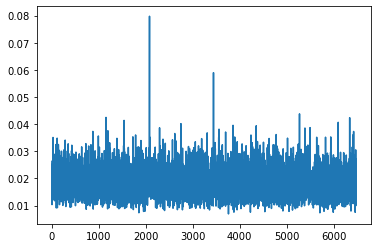

In [61]:
plt.plot(recon_loss)

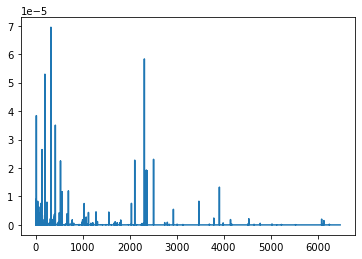

In [62]:
plt.plot(kld_loss)

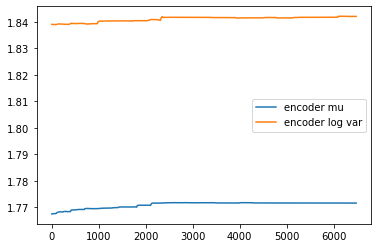

In [63]:
plt.figure()
# plt.plot(weight_norm['decoder'], label="decoder")
# plt.plot(weight_norm['encoder_before_last'], label="encoder b4 last")
plt.plot(weight_norm['encoder_mu'], label="encoder mu")
plt.plot(weight_norm['encoder_log_var'], label="encoder log var")
plt.legend()

In [37]:
def plot_raw_EEG(data, data2, n_sample):
    numChan = 24
    if len(data[0]) == 2: # torch batch
        x_data = data[:][0]
        x_data2 = data2[:][0]
    else:
        x_data = data
        x_data2 = data2
    row = col = int(np.sqrt(n_sample))
    fig = plt.figure(figsize=(row*10, col*10))
    outer = gridspec.GridSpec(row, col)
    print(n_sample)
    for i in range(n_sample):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg = x_data[i,:,:,:]
        npimg = np.reshape(npimg,(numChan,256))
        npimg2 = x_data2[i,:,:,:]
        npimg2 = np.reshape(npimg2,(numChan,256))

        yax = None
        for j in range(numChan):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.plot(range(256),npimg2[j,:],'r')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig

In [131]:
from scipy.io import savemat
def save_recons(exp):
    loader_test = enumerate(DataLoader(train_data, batch_size=len(train_data), shuffle=False))
    i,(x,y) = next(loader_test)
    sample,_,_ = trained_model(x)
    print(sample.shape)
    recons = np.reshape(sample.detach().numpy(), (-1,24,256))
    print(recons.shape)
    np.save(f'./experiment/{exp}/reconstructed.npy',recons)
    np.save(f'./experiment/{exp}/X_train.npy',np.reshape(x.detach().numpy(),(-1,24,256)))
    
    train_x_numpy = np.reshape(x.detach().numpy(),(-1,24,256))
    savemat(f'./experiment/{exp}/X_train.mat', {"train_X":train_x_numpy})
    savemat(f'./experiment/{exp}/X_recons.mat', {"recons_X": data})

torch.Size([20723, 1, 24, 256])
(20723, 24, 256)
